In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import seaborn as sns
import random
import os

# Define functions for analysis

In [2]:
def optimal_k (kmodes_dict, unique_ages):
    for elem in unique_ages:
        print("Test for ", elem)
        cost = []
        K = range(1,7)
        for num_clusters in list(K):
            kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 4, verbose=0)
            kmode.fit_predict(kmodes_dict[elem])
            cost.append(kmode.cost_)

        plt.plot(K, cost, 'bx-')
        plt.xlabel('No. of clusters')
        plt.ylabel('Cost')
        plt.title('Elbow Method For Optimal k')
        plt.show()

In [3]:
def find_clusters(kmodes_dict, unique_age, n):

    df = kmodes_dict[unique_age]

    kmode = KModes(n_clusters=n, init = "random", n_init = 5, verbose=0)
    clusters = kmode.fit_predict(df)
    
    df.insert(0, "Cluster", clusters, True) 
    df['Cluster'] = df['Cluster'] + 1
    
    return df

In [155]:
def pie_chart_plots(df, n_clusters, thresh, column_names, colors_dict, foldername):
    curr = os.getcwd()
    path = curr + '\\' + foldername + '\\'
    if not os.path.isdir(path):
        os.makedirs(path)
    i = 0
    
    for elem in colors_dict:
        
        fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5))

        print("n1 = ", len(df[df['Cluster'] == 1]), ", n2 = ", 
              len(df[df['Cluster'] == 2]), ", n3 = ", len(df[df['Cluster'] == 3]))
        print("p1 = ", round((len(df[df['Cluster'] == 1])/len(df)), 3), ", p2 = ", 
              round((len(df[df['Cluster'] == 2])/len(df)), 3), ", p3 = ", round((len(df[df['Cluster'] == 3])/len(df)), 3))

        for k in range(n_clusters):
            k+=1

            cluster = df[df.Cluster == k]
            counts = pd.Series(cluster[column_names[i]]).value_counts()
            counts = counts / sum (counts)
            a = counts[counts > thresh]
            a['other'] = counts[counts <= thresh].sum()

            axes[k-1].pie(a, labels = a.index, colors=[colors_dict[i][v] for v in a.keys()])
            axes[k-1].set_title('Cluster ' + str(k))
        
        fig.suptitle("Plots for Ages " + df['age_bin'][1])
        plt.savefig(fname  = (path + 'Plots for Ages ' + df['age_bin'][1] + '.png'))
        plt.show()
        
        i+=1

In [5]:
def create_color_assignments(cat_list, df_kmodes):
    dict_list = []
    
    for elem in cat_list:
        val_list = (df_kmodes[elem].unique()).tolist()
        num_colors = len(val_list)
        colors = ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
             for j in range(num_colors)]
        dict_val = dict(zip(val_list, colors))
        dict_val.update({'other':'#990000'})
        dict_list.append(dict_val)
        
    return(dict_list)

# Load and filter data

In [6]:
#read csv files and store them as pandas dataframes

raw_articles_df = pd.read_csv ('articles.csv')
raw_train_df = pd.read_csv ('transactions_train.csv')
raw_customers_df = pd.read_csv ('customers.csv')

In [7]:
#take sample of transaction data (20% of 32 million individual transactions)
#make sure datetime format is used for transaction dates

df_sample = raw_train_df.sample(frac=.2, replace=True, random_state=1)
pd.to_datetime(df_sample['t_dat']) 

12710949   2019-06-26
21463275   2020-01-20
6762380    2019-02-27
12325960   2019-06-22
491263     2018-09-29
              ...    
14547920   2019-07-26
20410570   2019-12-21
31413140   2020-09-12
20767676   2019-12-30
15640874   2019-08-18
Name: t_dat, Length: 6357665, dtype: datetime64[ns]

In [8]:
#add categorical data to transactions sample dataframe (code can be simplified)

id_type_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.product_type_name))
id_color_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.colour_group_name))
id_patt_dict = dict(zip(raw_articles_df.article_id, raw_articles_df.graphical_appearance_name))
id_age_dict = dict(zip(raw_customers_df.customer_id, raw_customers_df.age))

df_sample['product_type'] = df_sample['article_id'].map(id_type_dict)
df_sample['color'] = df_sample['article_id'].map(id_color_dict)
df_sample['pattern'] = df_sample['article_id'].map(id_patt_dict)
df_sample['age'] = df_sample['customer_id'].map(id_age_dict)

#df_sample

In [9]:
#extract the month from the date
#create age bins
#get rid of columns we won't use for now (price, sales channel, article id, date )
#month is created because it was sometimes used in analysis

df_kmodes = df_sample.set_index('customer_id')
df_kmodes['month'] = pd.DatetimeIndex(df_kmodes['t_dat']).month
df_kmodes['age_bin'] = pd.cut(df_kmodes['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])

df_kmodes = df_kmodes.drop(['price', 'sales_channel_id', 'article_id', 't_dat', 'age', 'month'], axis = 1)
df_kmodes.head()

,product_type,color,pattern,age_bin
customer_id,,,,
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa4e5d293b84201f619,Vest top,Orange,Solid,20-30
3e42e97cfc1cc859829830b9ef6f594e48e1441b77718919c6c014a12093c0e4,Leggings/Tights,Black,Solid,50-60
7afdec03c17e8d471db4641cde7c92f62a2338304779d87c2668ce2f40d47203,Sweater,Dark Blue,Stripe,0-20
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4dad7d88e410ae35fda,Dress,Yellowish Brown,All over pattern,70-80
88beadfe55a64381384b9c83334e3bb13be26374873b0dc108343f6bf3e7e9b9,T-shirt,Red,Solid,20-30


In [10]:
#get rid of the most common items (also items that don't change much seasonally/fashionably) as determined by previous analysis
#get rid of things barely purchased

df_kmodes2 = df_kmodes[df_kmodes.color != 'Black' ]
df_kmodes2 = df_kmodes2[df_kmodes2.color != 'White' ]
df_kmodes2 = df_kmodes2[df_kmodes2.color != 'Dark Blue' ]

df_kmodes2 = df_kmodes2[df_kmodes2.product_type != 'Trousers' ]

df_kmodes2 = df_kmodes2[df_kmodes2.groupby('product_type').product_type.transform(len) > 1000]
df_kmodes2 = df_kmodes2.dropna()

df_kmodes2.head()

,product_type,color,pattern,age_bin
customer_id,,,,
505d66fbc88b4300e6b4d11c26bfe4dd3857e21c07f86aa4e5d293b84201f619,Vest top,Orange,Solid,20-30
016fb4c5d61afcb3ff1b907c0d6f00ab9f4e4071ca22a4dad7d88e410ae35fda,Dress,Yellowish Brown,All over pattern,70-80
88beadfe55a64381384b9c83334e3bb13be26374873b0dc108343f6bf3e7e9b9,T-shirt,Red,Solid,20-30
9c8761fcb2106e9664601a1cd87b79bc99b9049b0dbe787eb1efeb178fa11c81,T-shirt,Beige,Colour blocking,30-40
78971a184035137737aecedfce711be93b6a603161d908a33313186bdbc78303,Cardigan,Light Beige,Solid,50-60


In [11]:
#Create dictionary of dataframes for cluster optimization

#create unique list of ages
unique_ages = df_kmodes2.age_bin.unique()

#create a data frame dictionary to store df
kmodes_dict = {elem : pd.DataFrame() for elem in unique_ages}

for key in kmodes_dict.keys():
    kmodes_dict[key] = df_kmodes2[:][df_kmodes2.age_bin == key]
    
#access with kmodes_dict['key']

Test for  20-30


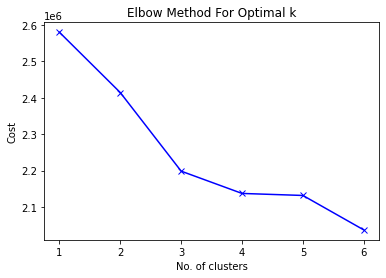

Test for  70-80


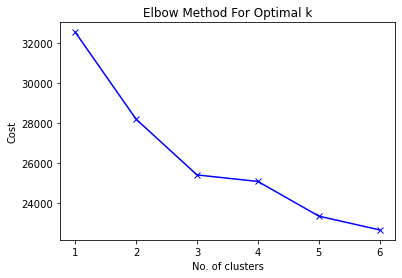

Test for  30-40


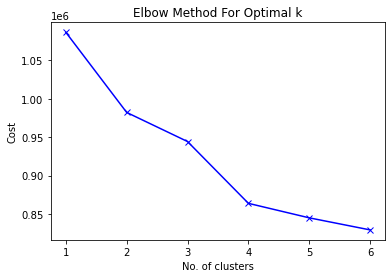

Test for  50-60


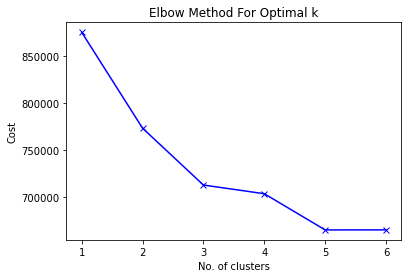

Test for  60-70


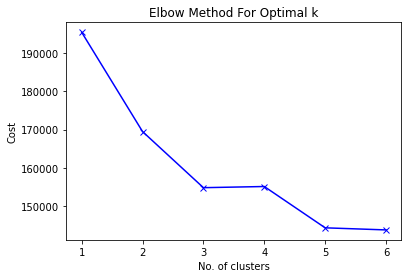

Test for  40-50


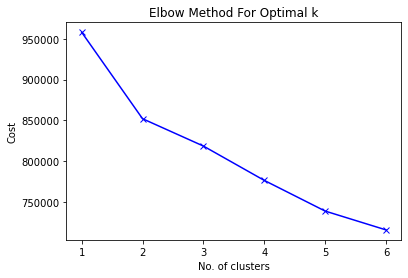

Test for  0-20


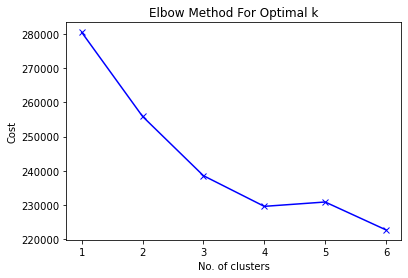

Test for  80-90


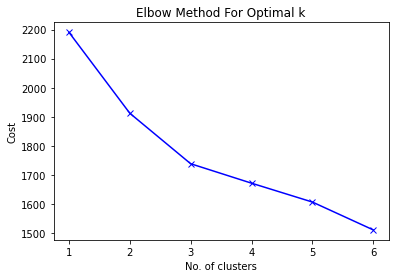

Test for  90-100


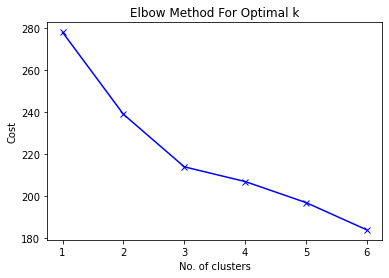

In [12]:
optimal_k (kmodes_dict, unique_ages)

In [13]:
#while a small portion of clusters show an elbow at k = 2 or k = 4, most show one at k = 3
#so, for the sake of continuity in the analysis, we will use k = n = 3

n = 3

df_20 = find_clusters(kmodes_dict, unique_ages[0], n)
df_70 = find_clusters(kmodes_dict, unique_ages[1], n)
df_30 = find_clusters(kmodes_dict, unique_ages[2], n)
df_50 = find_clusters(kmodes_dict, unique_ages[3], n)
df_60 = find_clusters(kmodes_dict, unique_ages[4], n)
df_40 = find_clusters(kmodes_dict, unique_ages[5], n)
df_0 = find_clusters(kmodes_dict, unique_ages[6], n)
df_80 = find_clusters(kmodes_dict, unique_ages[7], n)
df_90 = find_clusters(kmodes_dict, unique_ages[8], n)

In [14]:
df_list = [df_20, df_70, df_30, df_50, df_60, df_40, df_0, df_80,df_90]
cat_list = ['product_type', 'pattern', 'color']

In [15]:
dict_list = create_color_assignments(cat_list = cat_list, df_kmodes = df_kmodes2)
c_prod_dict = dict_list[0]
c_patt_dict = dict_list[1]
c_col_dict = dict_list[2]

Plots for Ages 20-30


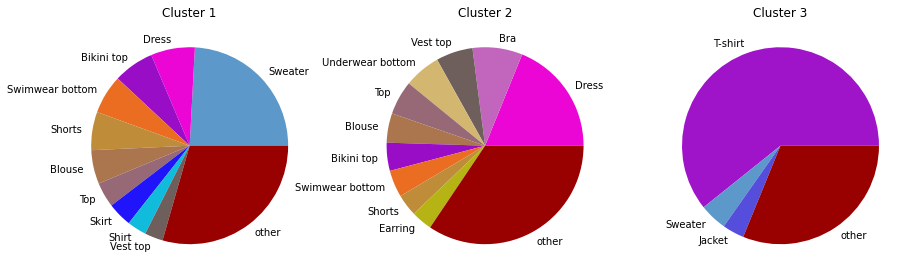

Plots for Ages 20-30


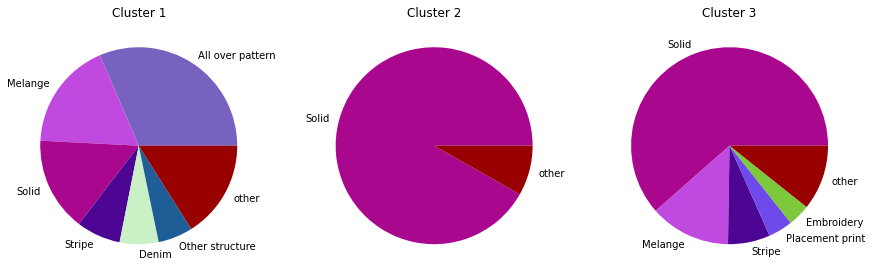

Plots for Ages 20-30


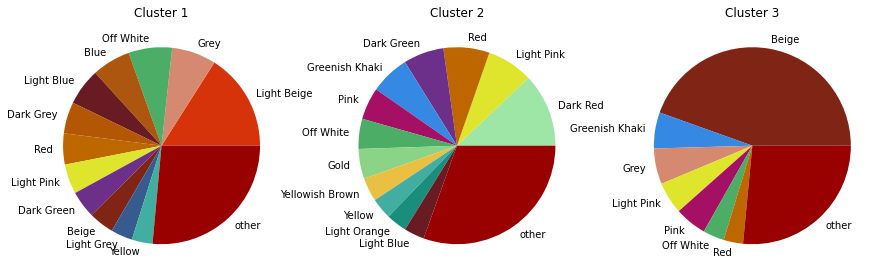

<Figure size 432x288 with 0 Axes>

In [16]:
#example
pie_chart_plots(df = df_20, n_clusters=3, thresh=0.03, column_names = cat_list, colors_dict=dict_list)

n1 =  568820 , n2 =  459310 , n3 =  103429
p1 =  0.503 , p2 =  0.406 , p3 =  0.091


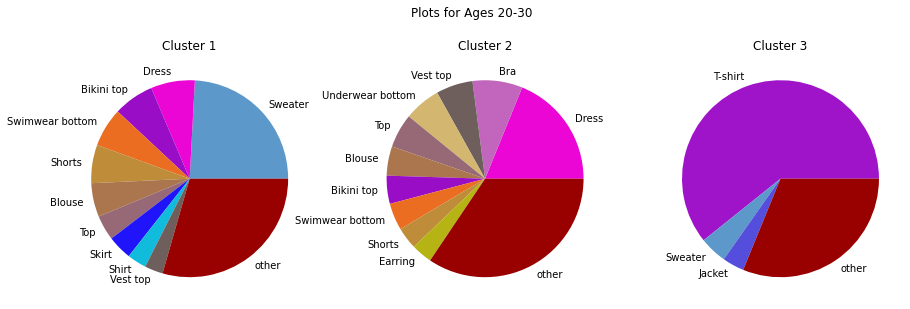

n1 =  568820 , n2 =  459310 , n3 =  103429
p1 =  0.503 , p2 =  0.406 , p3 =  0.091


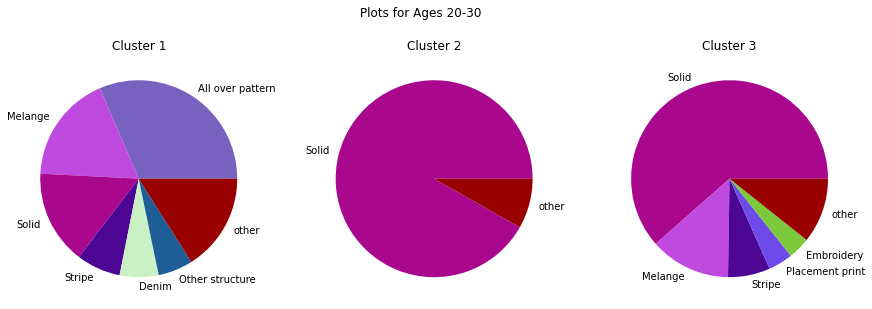

n1 =  568820 , n2 =  459310 , n3 =  103429
p1 =  0.503 , p2 =  0.406 , p3 =  0.091


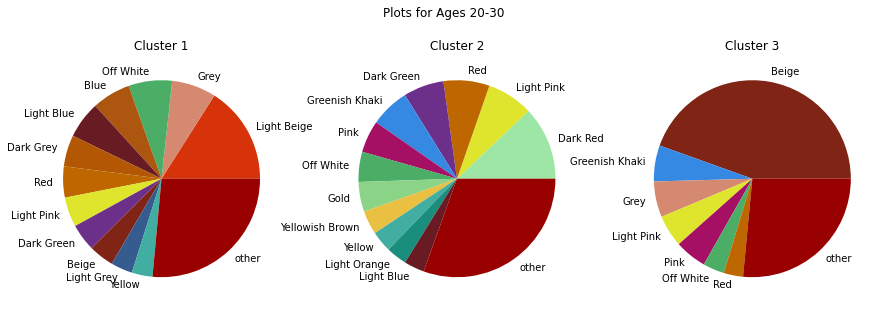

n1 =  8577 , n2 =  3619 , n3 =  2333
p1 =  0.59 , p2 =  0.249 , p3 =  0.161


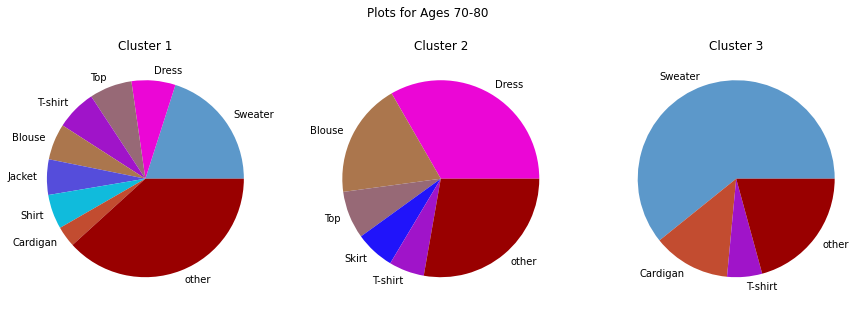

n1 =  8577 , n2 =  3619 , n3 =  2333
p1 =  0.59 , p2 =  0.249 , p3 =  0.161


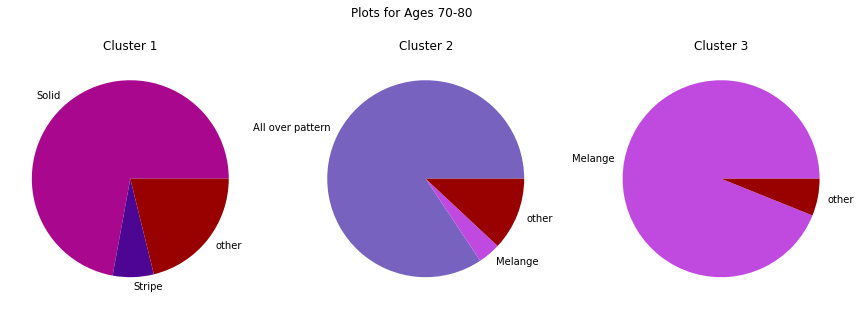

n1 =  8577 , n2 =  3619 , n3 =  2333
p1 =  0.59 , p2 =  0.249 , p3 =  0.161


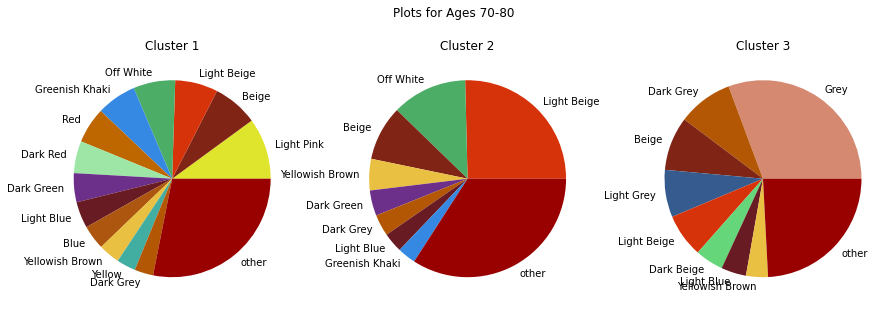

n1 =  185021 , n2 =  89975 , n3 =  198597
p1 =  0.391 , p2 =  0.19 , p3 =  0.419


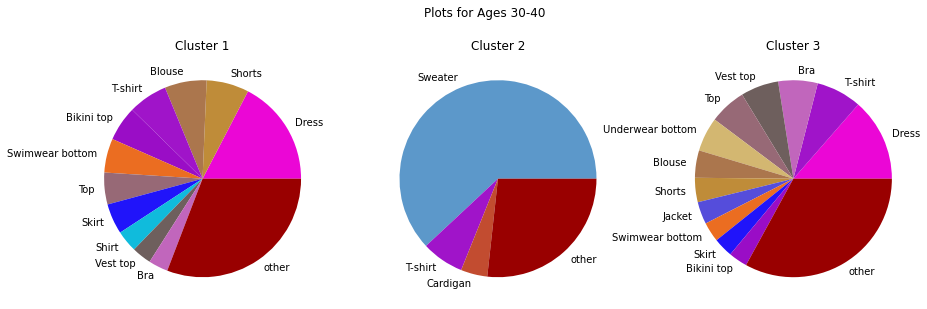

n1 =  185021 , n2 =  89975 , n3 =  198597
p1 =  0.391 , p2 =  0.19 , p3 =  0.419


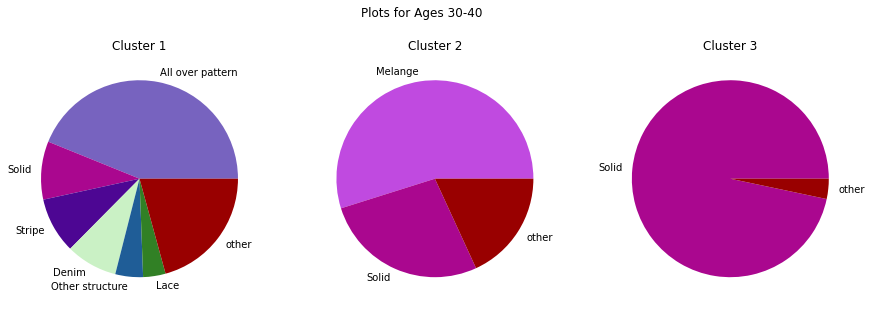

n1 =  185021 , n2 =  89975 , n3 =  198597
p1 =  0.391 , p2 =  0.19 , p3 =  0.419


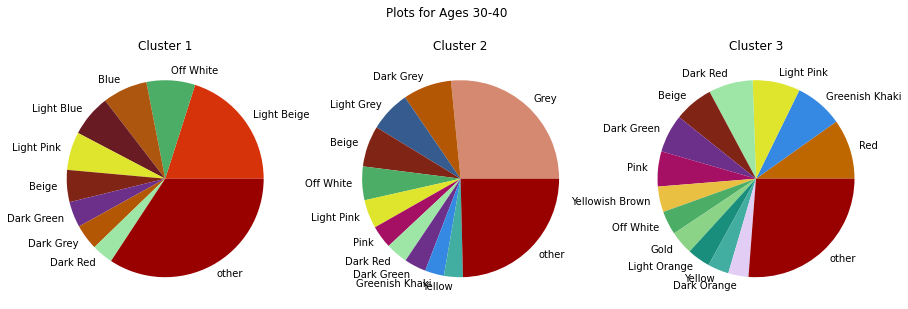

n1 =  138634 , n2 =  109594 , n3 =  134590
p1 =  0.362 , p2 =  0.286 , p3 =  0.352


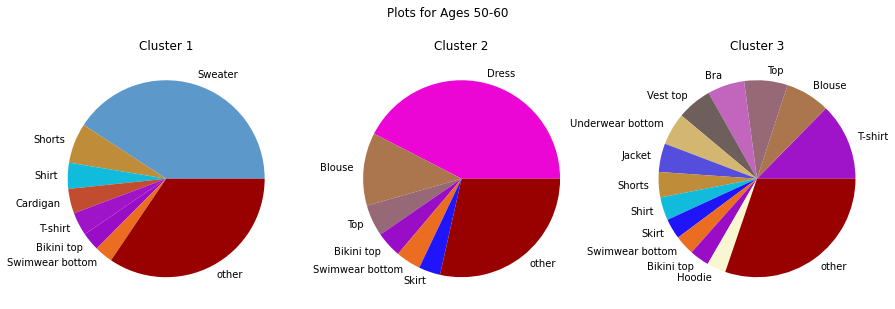

n1 =  138634 , n2 =  109594 , n3 =  134590
p1 =  0.362 , p2 =  0.286 , p3 =  0.352


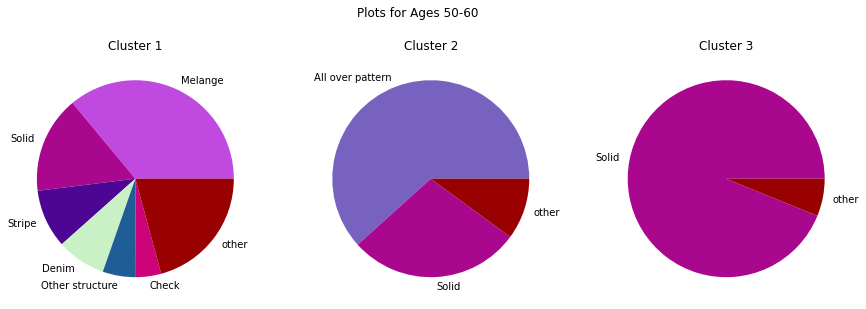

n1 =  138634 , n2 =  109594 , n3 =  134590
p1 =  0.362 , p2 =  0.286 , p3 =  0.352


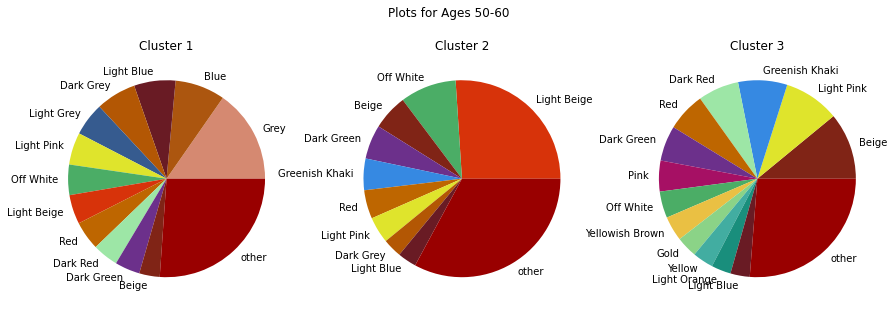

n1 =  44678 , n2 =  33477 , n3 =  8233
p1 =  0.517 , p2 =  0.388 , p3 =  0.095


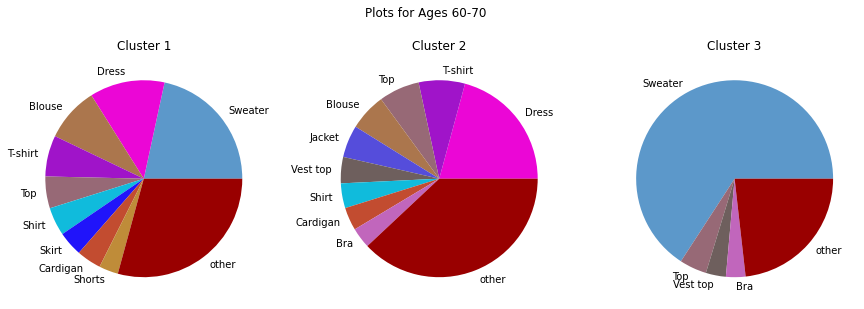

n1 =  44678 , n2 =  33477 , n3 =  8233
p1 =  0.517 , p2 =  0.388 , p3 =  0.095


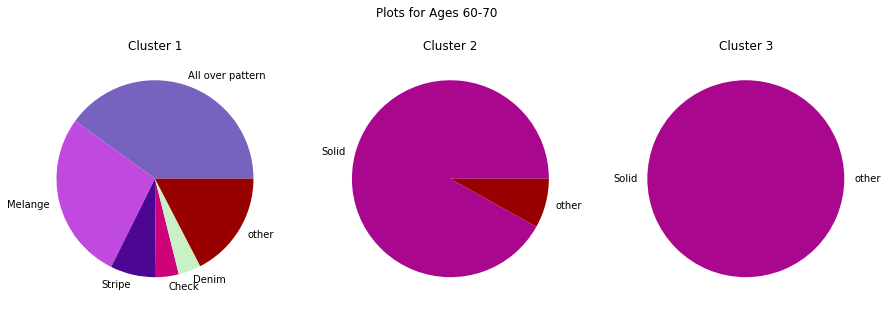

n1 =  44678 , n2 =  33477 , n3 =  8233
p1 =  0.517 , p2 =  0.388 , p3 =  0.095


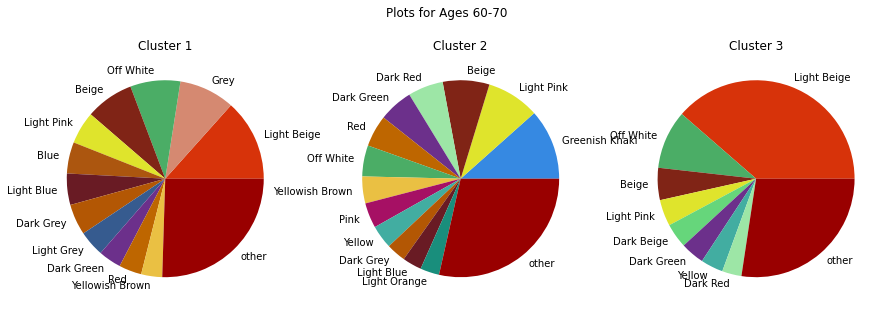

n1 =  287727 , n2 =  61777 , n3 =  62754
p1 =  0.698 , p2 =  0.15 , p3 =  0.152


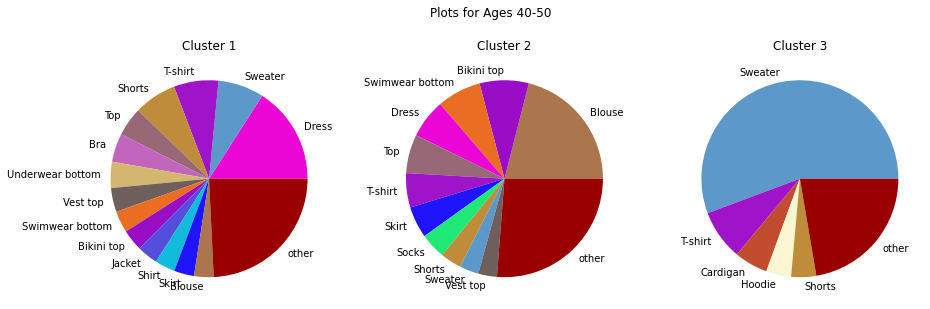

n1 =  287727 , n2 =  61777 , n3 =  62754
p1 =  0.698 , p2 =  0.15 , p3 =  0.152


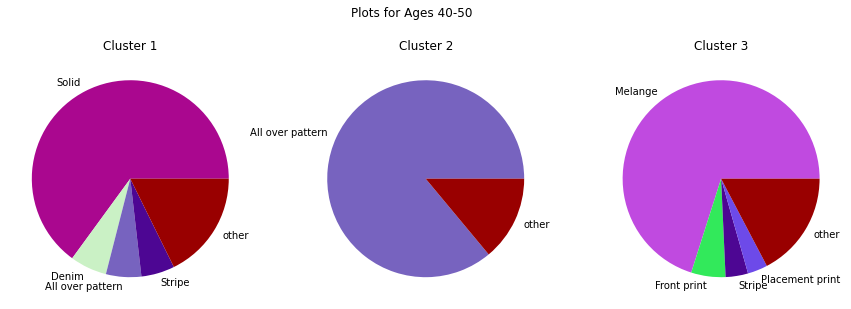

n1 =  287727 , n2 =  61777 , n3 =  62754
p1 =  0.698 , p2 =  0.15 , p3 =  0.152


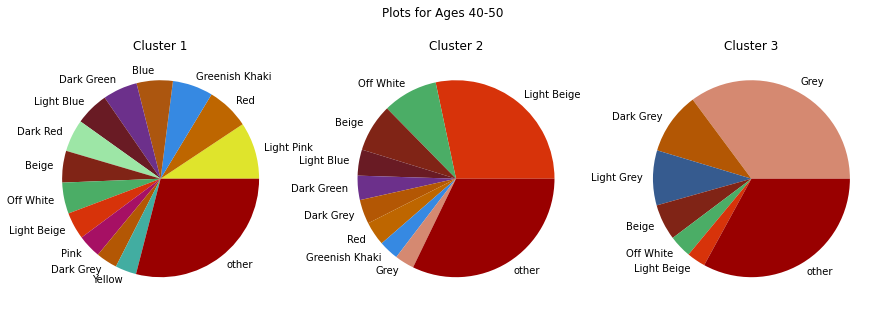

n1 =  39412 , n2 =  25670 , n3 =  56629
p1 =  0.324 , p2 =  0.211 , p3 =  0.465


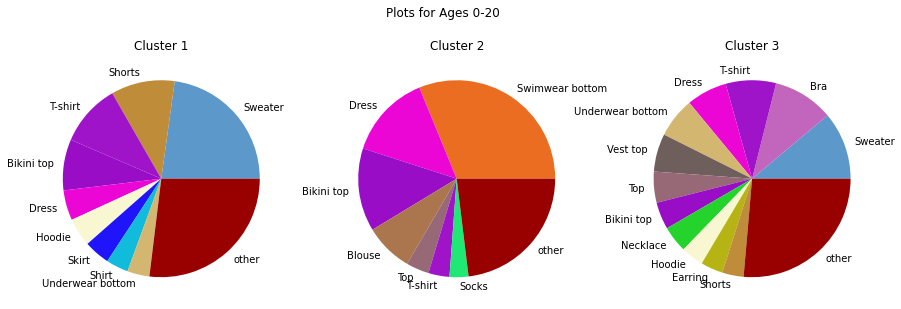

n1 =  39412 , n2 =  25670 , n3 =  56629
p1 =  0.324 , p2 =  0.211 , p3 =  0.465


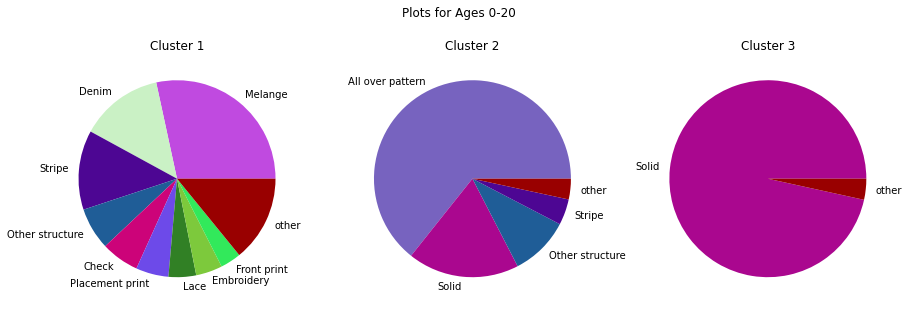

n1 =  39412 , n2 =  25670 , n3 =  56629
p1 =  0.324 , p2 =  0.211 , p3 =  0.465


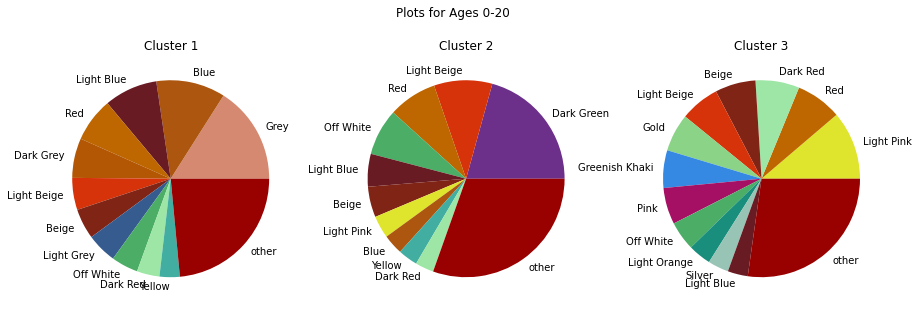

n1 =  647 , n2 =  149 , n3 =  190
p1 =  0.656 , p2 =  0.151 , p3 =  0.193


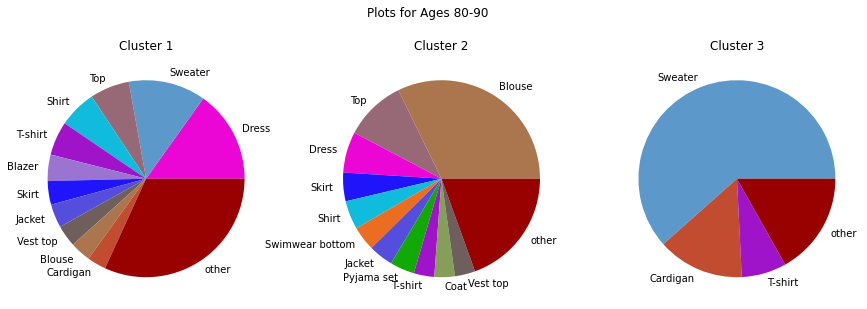

n1 =  647 , n2 =  149 , n3 =  190
p1 =  0.656 , p2 =  0.151 , p3 =  0.193


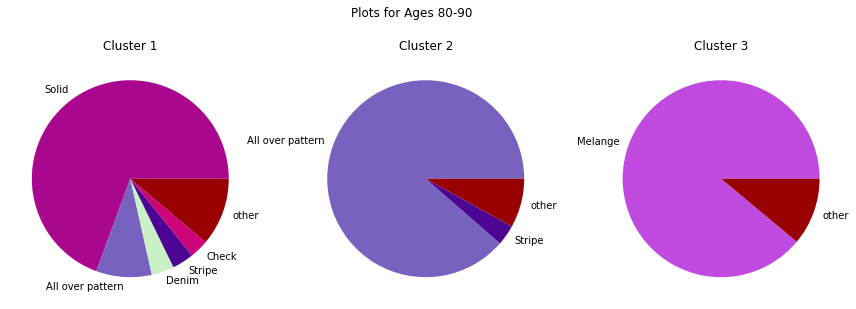

n1 =  647 , n2 =  149 , n3 =  190
p1 =  0.656 , p2 =  0.151 , p3 =  0.193


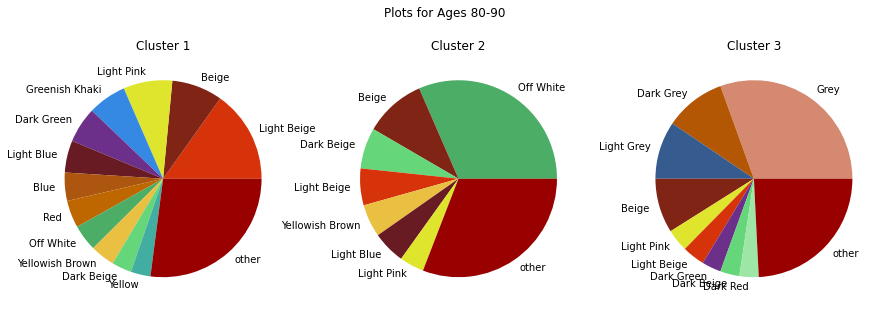

n1 =  48 , n2 =  63 , n3 =  14
p1 =  0.384 , p2 =  0.504 , p3 =  0.112


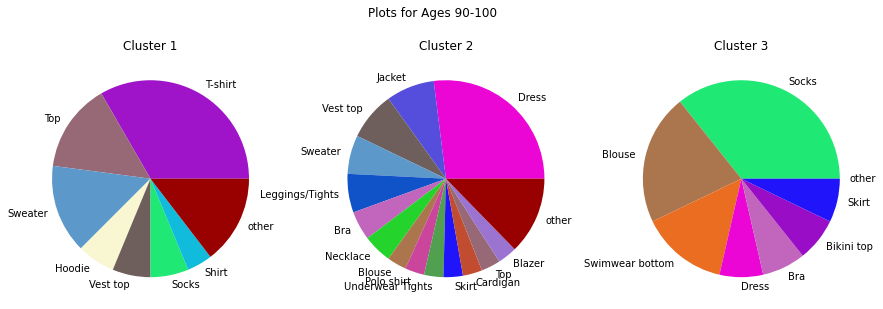

n1 =  48 , n2 =  63 , n3 =  14
p1 =  0.384 , p2 =  0.504 , p3 =  0.112


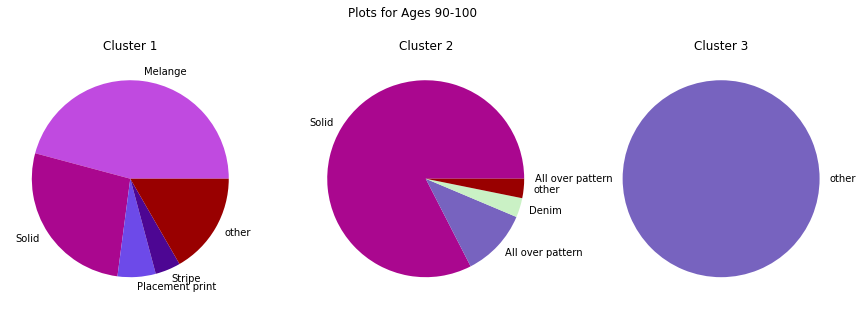

n1 =  48 , n2 =  63 , n3 =  14
p1 =  0.384 , p2 =  0.504 , p3 =  0.112


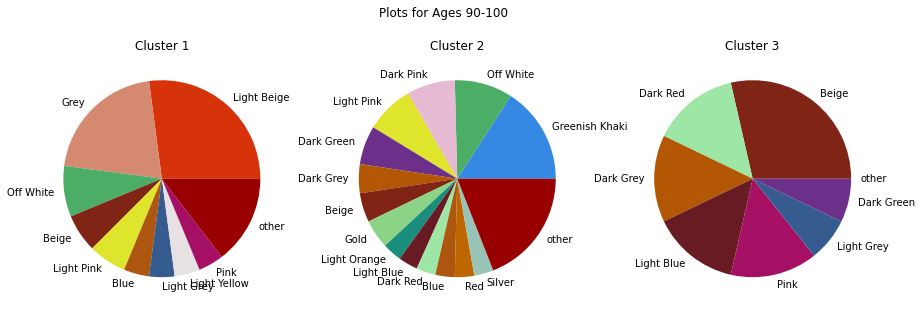

In [166]:
#run for all age groups
for df in df_list:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cat_list, colors_dict=dict_list, foldername = 'All')

In [164]:
patt_list = []
cpatt_list = []

patt_list.append(dict_list[1])
cpatt_list.append(cat_list[1])

n1 =  568820 , n2 =  459310 , n3 =  103429
p1 =  0.503 , p2 =  0.406 , p3 =  0.091


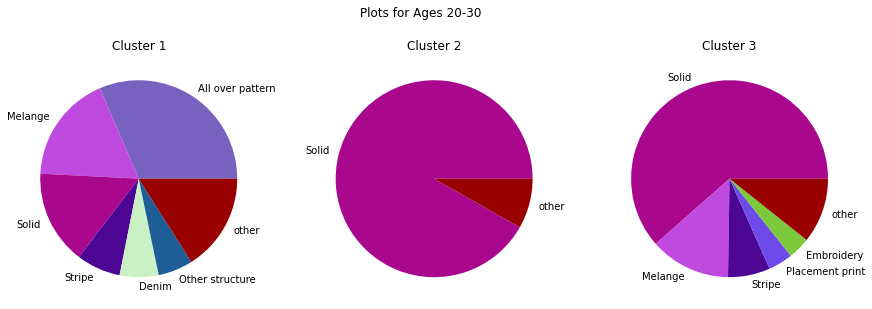

n1 =  8577 , n2 =  3619 , n3 =  2333
p1 =  0.59 , p2 =  0.249 , p3 =  0.161


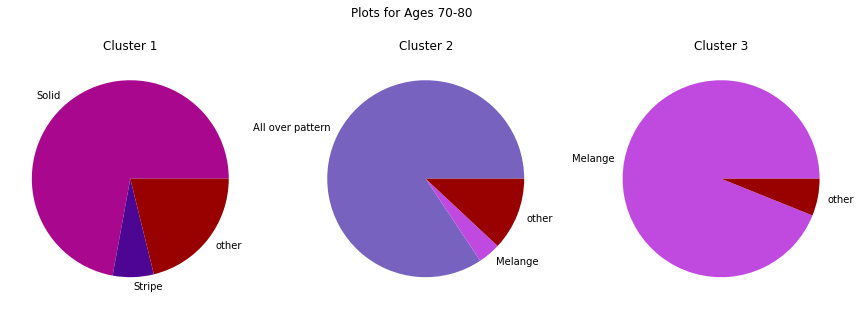

n1 =  185021 , n2 =  89975 , n3 =  198597
p1 =  0.391 , p2 =  0.19 , p3 =  0.419


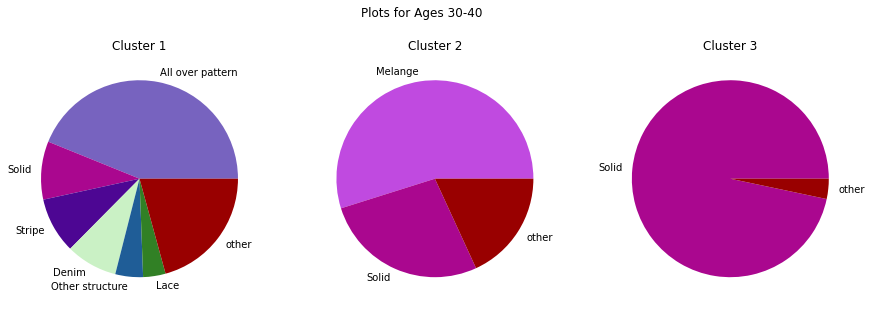

n1 =  138634 , n2 =  109594 , n3 =  134590
p1 =  0.362 , p2 =  0.286 , p3 =  0.352


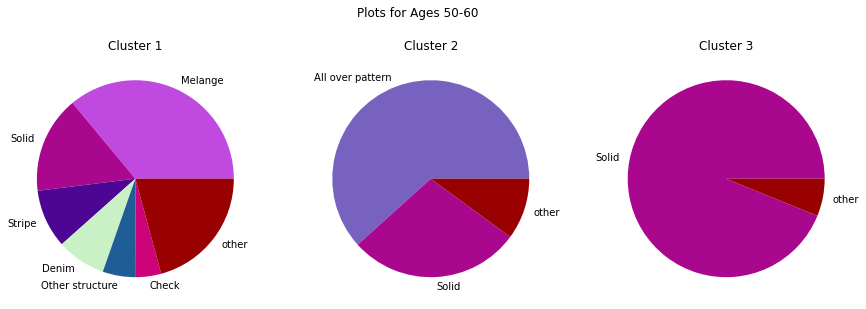

n1 =  44678 , n2 =  33477 , n3 =  8233
p1 =  0.517 , p2 =  0.388 , p3 =  0.095


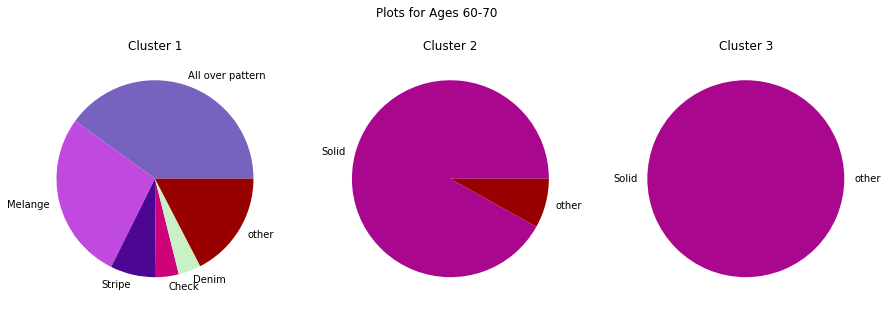

n1 =  287727 , n2 =  61777 , n3 =  62754
p1 =  0.698 , p2 =  0.15 , p3 =  0.152


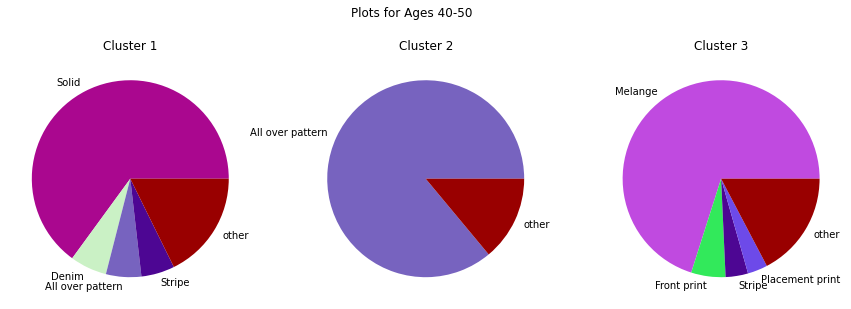

n1 =  39412 , n2 =  25670 , n3 =  56629
p1 =  0.324 , p2 =  0.211 , p3 =  0.465


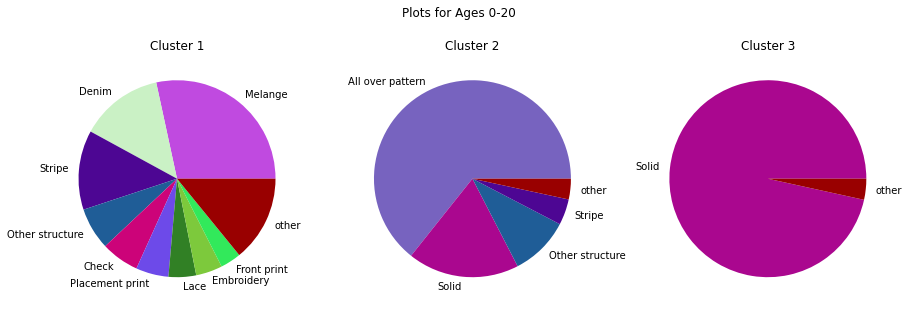

n1 =  647 , n2 =  149 , n3 =  190
p1 =  0.656 , p2 =  0.151 , p3 =  0.193


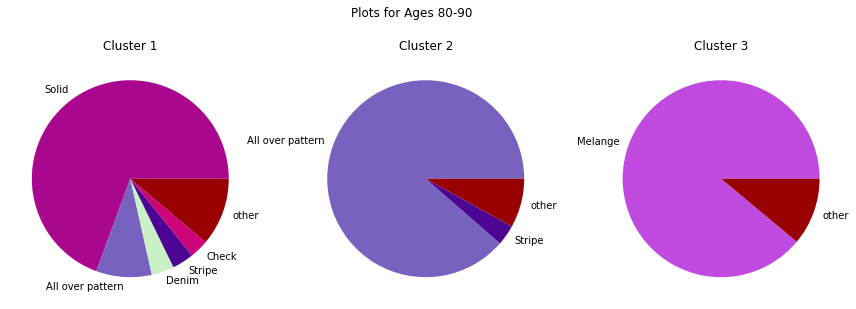

n1 =  48 , n2 =  63 , n3 =  14
p1 =  0.384 , p2 =  0.504 , p3 =  0.112


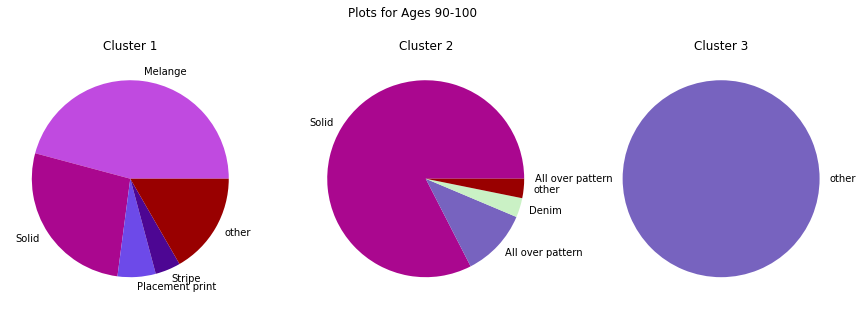

In [165]:
#run for patterns only 
for df in df_list:
    pie_chart_plots(df = df, n_clusters=3, thresh=0.03, column_names = cpatt_list, colors_dict=patt_list, foldername = 'Patterns')

# Discussion

I observe three consistent clusters across all ages that I classisfy as Everyday, Summer, and Fall

These clusters have a few characteristics. For example, summer is characterized by dresses, all-over patterns, and blouses for older groups and swimwear for younger groups. Alternatively, Fall is characterized by melange, cardigans, and hoodies for older groups and sweaters for younger groups. Everyday purchases tend to be solid colors, suggesting basic varieties of attire. 

The Summer and Fall clusters tend to be much smaller (up to 4x) than the Everyday group, suggesting sub-groups buying specifically for the seasons. Yet, the buying patterns do vary across age groups, as described by some of the example characteristics above. 

# Considering Cluster sizes 

In [187]:
total_values = []
prop_values = []
for elem in df_list:
    total_values.append(elem['Cluster'].value_counts())
    prop_values.append(elem['Cluster'].value_counts()/len(elem))

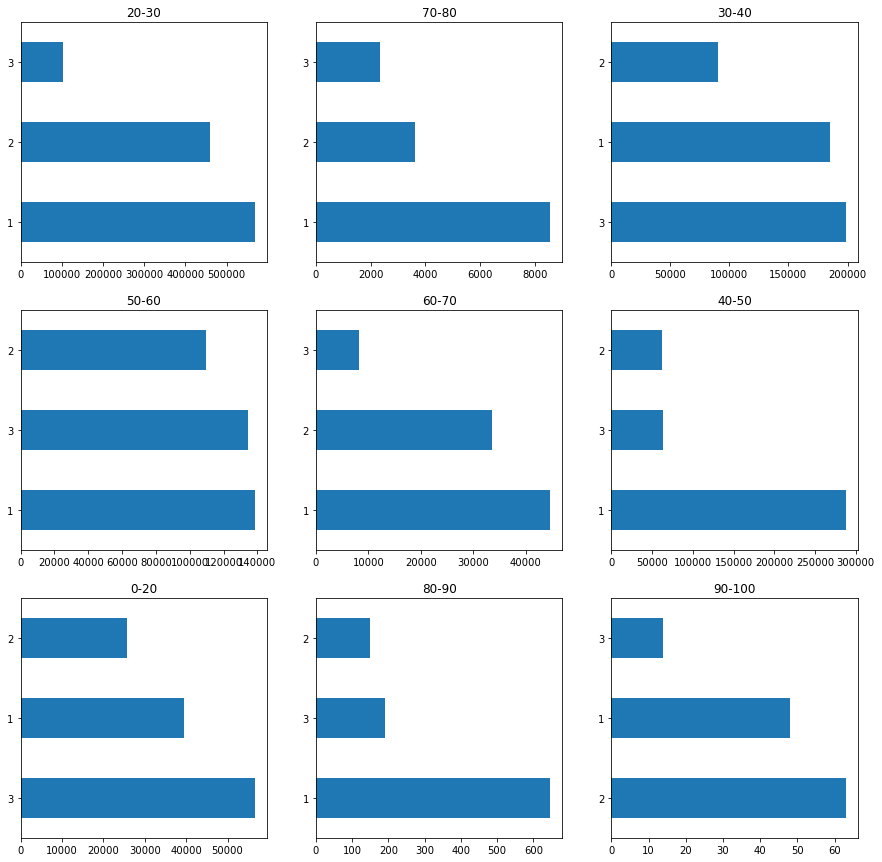

In [249]:
n = 0
plt.figure(figsize=(15, 15))

for elem in df_list: 
    ax = plt.subplot(3, 3, n + 1)
    elem.Cluster.value_counts().plot(kind = 'barh', ax = ax)
    ax.set_title(elem['age_bin'][1])
    
    n+=1
    
plt.show()

# Misc

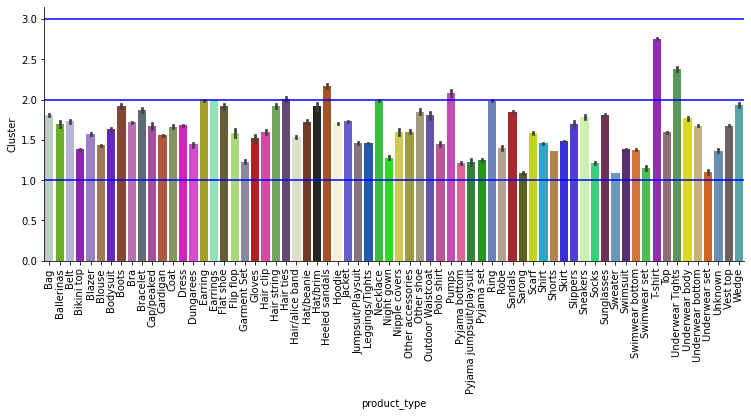

In [18]:
#this is an example of what a bar chart could look like
#i think these are harder to read and interpret with so many comparisons

h = sns.catplot(data=df_20.sort_values(['product_type']), x="product_type", y="Cluster", kind = "bar", palette = dict_list[0], height=4.27, aspect=10.7/4.27)
h.set_xticklabels(rotation = 90)
plt.axhline(y = 1, color = 'b', linestyle = '-')
plt.axhline(y = 2, color = 'b', linestyle = '-')
plt.axhline(y = 3, color = 'b', linestyle = '-')